In [1]:
import json
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule#
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP, SNOBFIT, COBYLA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Will store matrices in sparse form


/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2O_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'B+_STO-3G_SINGLET'])

Number of terms in the ansatz: 60
BeH2_STO-3G_SINGLET reaches chemical accuracy for 7-qubit CS-VQE


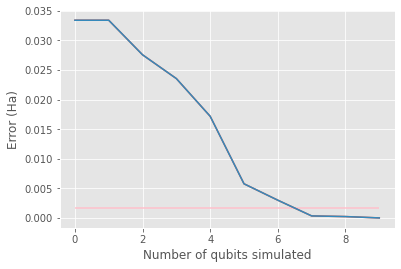

In [48]:
speciesname = "BeH2_STO-3G_SINGLET"
mol_model    = model_data[speciesname]
anz_op = mol_model['ansatze']['excite3']
mol_circ = cs_circ.cs_vqe_circuit(model_data=mol_model)
num_sim_q = mol_circ.chem_acc_num_q
print('Number of terms in the ansatz:', len(anz_op))
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

# Performing the simulation *without* noise

In [ ]:
mol_circ.sufficient_anz_terms(anz_terms=anz_op)

Testing operator 1/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 2/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 3/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 4/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 5/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 6/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 7/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 8/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 9/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 10/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 11/60
*   Pe

Testing operator 24/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 25/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 26/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 27/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 28/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 29/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 30/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 31/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 32/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 33/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 34/

Testing operator 48/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 49/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 50/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 51/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 52/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 53/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 54/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 55/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 56/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 57/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 58/

runtime_job._start_websocket_client:WARNING:2021-11-10 13:44:29,121: An error occurred while streaming results from the server for job c65sj28bf44tds2vr06g:
Traceback (most recent call last):
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tweaving/.local/lib/python3.8/site-packages/websocket/_app.py", line 369, in run_for

Testing operator 12/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 13/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 14/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 15/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 17/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 18/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 19/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 20/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 21/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 22/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 23/

runtime_job._start_websocket_client:WARNING:2021-11-10 13:45:21,569: An error occurred while streaming results from the server for job c65sjatr3kuo3udbj0ig:
Traceback (most recent call last):
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tweaving/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tweaving/.local/lib/python3.8/site-packages/websocket/_app.py", line 369, in run_for

Testing operator 42/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 43/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 44/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 45/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 46/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 47/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 48/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 49/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 50/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 51/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 52/

Testing operator 6/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 8/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 9/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 10/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 11/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 12/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 13/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 14/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 15/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 17/60
*   Performing 7-qubit CS-VQE over qubit positions 7, 6, 5, 4, 3, 2, 1 ...
Testing operator 18/60


In [39]:
#suff_terms=['YXIIIIXX', 'IYIIXIXX', 'XZIIZXYX', 'IIIIXXXY', 'IIIIXZYI'] #LiH
#suff_terms = ['IIYXX', 'IXIYX', 'YIIXX', 'XIIYX', 'IYIXX'] #Be
#suff_terms = ['IXIYX', 'YIIXX'] #B+
#suff_terms = ['IYIXX'] #C
#suff_terms = ['YYIIYXII', 'XXIIYZZX', 'YXIIIIYY', 'YXIIIXXI'] #HF
suff_anz_op = {op:anz_op[op] for op in suff_terms}

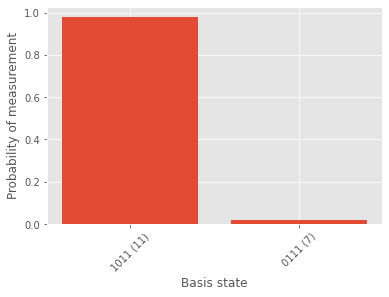

*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...


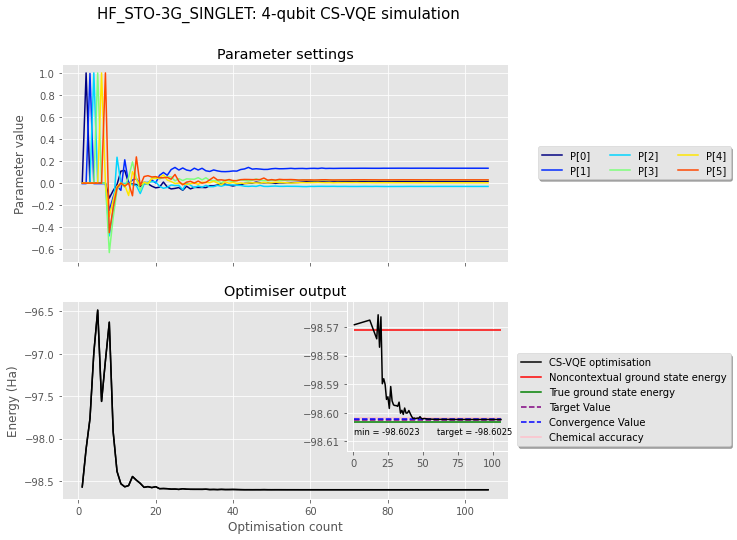

In [40]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=suff_anz_op, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=COBYLA(maxiter=1000), 
                                 param_bound=np.pi,
                                 show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [7]:
#import json 

#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
    
#with open("data/IBMQ-runtime/"+speciesname+"/statevectorsim.json", "w") as outfile: 
#    json.dump(data, outfile)

In [8]:
#param_hist = [config for param, config in cs_vqe_results['params'].items()]
#init_params = np.array(list(zip(*param_hist))[-1])

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [9]:
from qiskit import IBMQ
from utils.circuit_execution_tools import remote_circuit_execution
from matplotlib import pyplot as plt
plt.style.use('ggplot')
with open('data/token.txt', 'r') as file:
    TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [10]:
#data, raw_data = remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=150, qfi_resamples=150, zero_params=True)

In [11]:
#fig = plot.plot_parameter_settings_alt(data, log_error=True)

In [12]:
provider = IBMQ.get_provider(hub='ibm-q',group='open',project='main')
backends = [b.name() for b in provider.backends() if b.configuration().num_qubits==5]
backends

['ibmq_santiago',
 'ibmq_bogota',
 'ibmq_lima',
 'ibmq_belem',
 'ibmq_quito',
 'ibmq_manila']

In [34]:
ibmq_result = remote_circuit_execution(mol_circ=mol_circ, 
                                       num_sim_q=num_sim_q, 
                                       anz_op=suff_anz_op,
                                       backend="ibmq_bogota",
                                       maxiter=100, 
                                       qfi_resamples=100)

KeyboardInterrupt: 

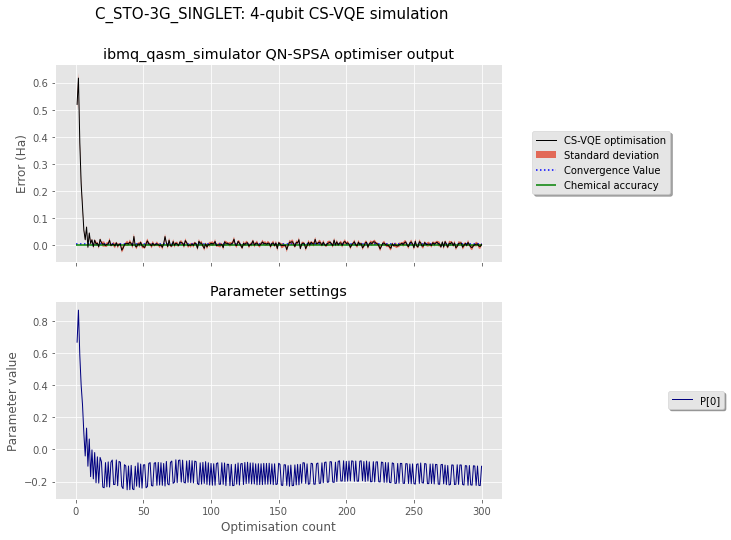

In [29]:
fig=plot.plot_parameter_settings_alt(ibmq_result[0], title=title)